In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import jax

In [2]:
def func_reshape(image, max_size):
    p = len(image)
    if p < max_size:
        image = np.hstack((np.zeros((p,(max_size-p)//2)), image, np.zeros((p,(max_size-p)//2))))
        image = np.vstack((np.zeros(((max_size-p)//2,max_size)), image, np.zeros(((max_size-p)//2,max_size))))
    return image

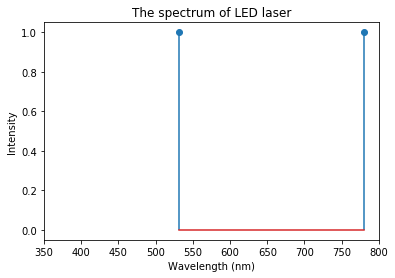

In [3]:
lam_x = np.array([0.532, 0.780])
inten_x = np.array([1, 1])
# lam_x = np.array([0.460, 0.5, 0.532, 0.57, 0.66, 0.78])
# inten_x = np.array([0, 0, 1, 0, 0.00, 1])

max_index = inten_x.argmax()
lam_depth = len(lam_x)

lam = lam_x[max_index]

plt.stem(lam_x*1.0e3, inten_x, use_line_collection=True)
plt.xlim(350,800)
plt.title('The spectrum of LED laser')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

In [4]:
logo = plt.imread('EK_1616x1616.png')[:,:,0]
ll, mm = 1616, 2048

logo = (logo>0.5)*1

logo = np.hstack((np.zeros((ll,(mm-ll)//2)),logo,np.zeros((ll,(mm-ll)//2))))
logo = np.vstack((np.zeros(((mm-ll)//2,mm)),logo,np.zeros(((mm-ll)//2,mm))))

# logo = logo[::16,::16]
# logo = np.kron(logo, np.ones((8,8)))
logo = logo.astype(np.int8)

p = logo.shape[0]                # pxp target image

target_coords = np.where( logo > 0 )

target = logo
print("Target image size: ",p,"x",p,'\n')

lam = lam_x[max_index]
max_size = int(p*lam_x[-1]/lam)
max_size += max_size%2

m = max_size*max_size            # number of pixels in target image

d_n = 0.6                        # Refractive index of Photoresist : 1.6
q   = int(1.0*p)
d   = 2.0                        # SLM pitch: 2 micrometer
f   = p/lam*4                    # focal length

# list of SLM pixels contained in the pupil
slm_x, slm_y = np.meshgrid( np.arange(q), np.arange(q) )
slm_x = ( slm_x - int(q/2) ) * d
slm_y = ( slm_y - int(q/2) ) * d
slm_x = slm_x.astype(np.float32)
slm_y = slm_y.astype(np.float32)

pup_ind = np.kron(range(q),np.ones(q,dtype=np.int8)), \
          np.kron(np.ones(q,dtype=np.int8),range(q))

n = pup_ind[0].shape[0]

SLM_size = int(d*q)              # um
IMG_size = int(lam_x[-1]*f/d)    # um
IMG_pitch = IMG_size/p           # um

print("The number of SLM pixels: ",n)
print("The number of IMG pixels: ",m)
print("Focal length: ", f*1e-3, "(mm)")
print("SLM pitch:", d, "(um)")
print("IMG pitch:", IMG_pitch, "(um)")
print("SLM size: ", SLM_size, "x", SLM_size, "(um)")
print("IMG size: ", IMG_size, "x", IMG_size, "(um)")
print("Fresnel number: ", SLM_size**2/4/lam/f)
print("Refractive index: ", d_n)
print("Wavelength :",lam)

Target image size:  2048 x 2048 

The number of SLM pixels:  4194304
The number of IMG pixels:  9012004
Focal length:  15.398496240601505 (mm)
SLM pitch: 2.0 (um)
IMG pitch: 2.93212890625 (um)
SLM size:  4096 x 4096 (um)
IMG size:  6005 x 6005 (um)
Fresnel number:  512.0
Refractive index:  0.6
Wavelength : 0.532


In [5]:
# filename = 'data_jhk_IMG2048x2048_SLM2048x2048_nlevels64.csv'
# n_levels = 64
# phase_disc = np.loadtxt(filename)
# phase_disc *= n_levels/256

# phase_ls = phase_disc/n_levels*2*np.pi

# LC_d_ls = phase_ls * lam/(2*np.pi*d_n)

In [6]:
filename = 'LC_d_ls_3_loss0_2048x2048.csv'
# filename = 'LC_d_ls_3_copy2048x2048_1.3.csv'
LC_d_ls = np.loadtxt(filename, dtype=np.float64)
print(filename)

LC_d_ls_3_loss0_2048x2048.csv


In [7]:
quad_phase_3d = np.zeros((q,q,lam_depth), dtype=np.complex64)
for i in range(lam_depth):
    quad_phase_3d[:,:,i] = np.exp(1j*np.pi/(lam_x[i]*f)*( slm_x**2 + slm_y**2 ))

intensity_ls = np.zeros((max_size,max_size,lam_depth), dtype=np.float32)

for i in range(lam_depth):
    phase_temp = LC_d_ls*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_temp)*quad_phase_3d[:,:,i]
    zzz = np.array(inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n)
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = jax.image.resize(zzz, (img_size, img_size), "nearest")
    zzz = func_reshape(zzz, max_size)
    intensity_ls[:,:,i] += np.abs(zzz)**2
del phase_temp, xxx, zzz

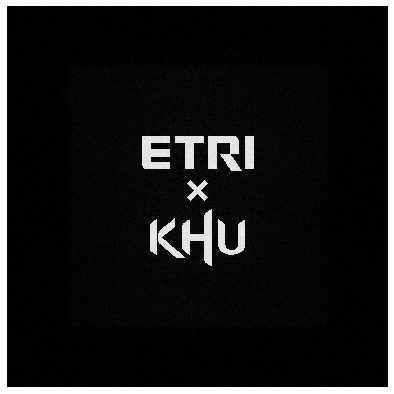

In [8]:
intensity_holography = np.zeros((max_size,max_size),dtype=np.float32)
for i in range(lam_depth):
    intensity_holography += intensity_ls[:,:,i]

plt.figure(figsize=(7,7))
plt.imshow(intensity_holography, cmap='gray')
plt.axis('off')
plt.show()

In [9]:
# filename = 'IMG%dx%d' %(p,p)
# plt.imsave(filename+'.png', intensity_holography, format='png', cmap='gray' )

# 여러 파장에 대한 실험 결과

In [10]:
# plt.figure(figsize=(20,6))
# for i in range(lam_depth):
#     plot_num = 161+i
#     plt.subplot(plot_num)
#     plt.imshow(intensity_ls[:,:,i], cmap='gray')
#     plt.axis('off')
#     plt.title('Expected intensity (%d um)' %(lam_x[i]*1e+03))
# plt.show()

# 최종 생성된 이미지 (f=p/lam*4)

In [11]:
img_intensity = np.zeros((max_size,max_size), dtype=np.float32)

for i in range(lam_depth):
    img_intensity += intensity_ls[:,:,i]

# 거리 별로 이미지 생성 확인

In [12]:
f = p/lam_x[0]*4
quad_phase_3d = np.zeros((q,q,lam_depth), dtype=np.complex64)
for i in range(lam_depth):
    quad_phase_3d[:,:,i] = np.exp(1j*np.pi/(lam_x[i]*f)*( slm_x**2 + slm_y**2 ))

intensity_ls = np.zeros((max_size,max_size,lam_depth), dtype=np.float32)

for i in range(lam_depth):
    phase_temp = LC_d_ls*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_temp)*quad_phase_3d[:,:,i]
    zzz = np.array(inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n)
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = jax.image.resize(zzz, (img_size, img_size), "nearest")
    zzz = func_reshape(zzz, max_size)
    intensity_ls[:,:,i] += np.abs(zzz)**2
del phase_temp, xxx, zzz

img_intensity_1 = np.zeros((max_size,max_size), dtype=np.float32)

for i in range(lam_depth):
    img_intensity_1 += intensity_ls[:,:,i]

In [13]:
f = p/lam_x[1]*4
quad_phase_3d = np.zeros((q,q,lam_depth), dtype=np.complex64)
for i in range(lam_depth):
    quad_phase_3d[:,:,i] = np.exp(1j*np.pi/(lam_x[i]*f)*( slm_x**2 + slm_y**2 ))

intensity_ls = np.zeros((max_size,max_size,lam_depth), dtype=np.float32)

for i in range(lam_depth):
    phase_temp = LC_d_ls*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_temp)*quad_phase_3d[:,:,i]
    zzz = np.array(inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n)
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = jax.image.resize(zzz, (img_size, img_size), "nearest")
    zzz = func_reshape(zzz, max_size)
    intensity_ls[:,:,i] += np.abs(zzz)**2
del phase_temp, xxx, zzz

img_intensity_2 = np.zeros((max_size,max_size), dtype=np.float32)

for i in range(lam_depth):
    img_intensity_2 += intensity_ls[:,:,i]

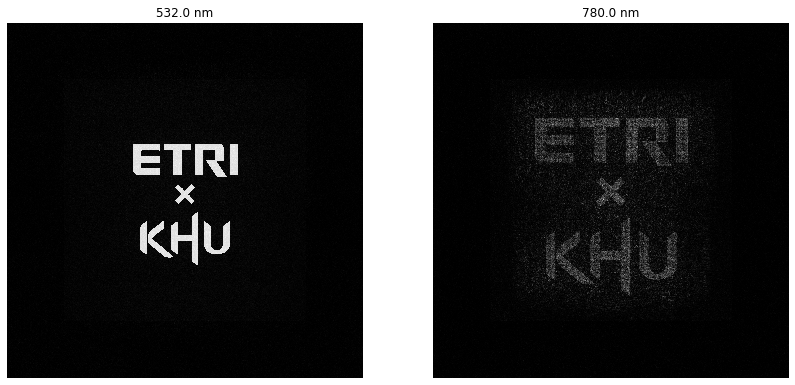

In [14]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(img_intensity_1, cmap='gray')
plt.title('%.1f nm' %(lam_x[0]*1e+03))
plt.axis('off')

plt.subplot(122)
plt.imshow(img_intensity_2, cmap='gray')
plt.title('%.1f nm' %(lam_x[1]*1e+03))
plt.axis('off')

plt.show()

In [15]:
filename1 = 'IMG_loss0_532_%dx%d' %(p,p)
plt.imsave(filename1+'.png', img_intensity_1, format='png', cmap='gray')

filename2 = 'IMG_loss0_780_%dx%d' %(p,p)
plt.imsave(filename2+'.png', img_intensity_2, format='png', cmap='gray')

print(filename1)
print(filename2)

IMG_loss0_532_2048x2048
IMG_loss0_780_2048x2048
